In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold

In [3]:
import os
os.chdir(r'd:\reconstrucao_estatistica_pesqueira\reconstrucao_estatistica_brasileira\recontrucao_da_estatistica_pesqueira_brasileira')
print(os.getcwd())

d:\reconstrucao_estatistica_pesqueira\reconstrucao_estatistica_brasileira\recontrucao_da_estatistica_pesqueira_brasileira


In [4]:
df = pd.read_excel('curvas_de_propocao/Lula_ind_prop.xlsx')
df.head()

,Ano,Proporção
0,1978,0.152672
1,1979,0.410828
2,1980,0.048913
3,1981,0.218216
4,1982,0.116959


In [6]:
df_x0= pd.DataFrame(df, columns= ['Ano', 'Proporção'])

df_x0= df_x0.drop_duplicates(subset= 'Proporção')

In [7]:
x = np.array(df_x0['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(df_x0['Proporção'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

In [10]:
class PrintEveryNEpochs(tf.keras.callbacks.Callback):
    def __init__(self, N):
        super(PrintEveryNEpochs, self).__init__()
        self.N = N

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.N == 0:
            print(f"Epoch {epoch + 1}: loss = {logs['loss']}")

In [11]:
def leaky_relu(x):
    return tf.nn.RMSprop(x, alpha=0.01)

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1264.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


Epoch 100: loss = 0.18136706948280334
Epoch 200: loss = 0.24641093611717224
Epoch 300: loss = 0.12420517206192017
Epoch 400: loss = 0.1111801266670227
Epoch 500: loss = 0.09275394678115845
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


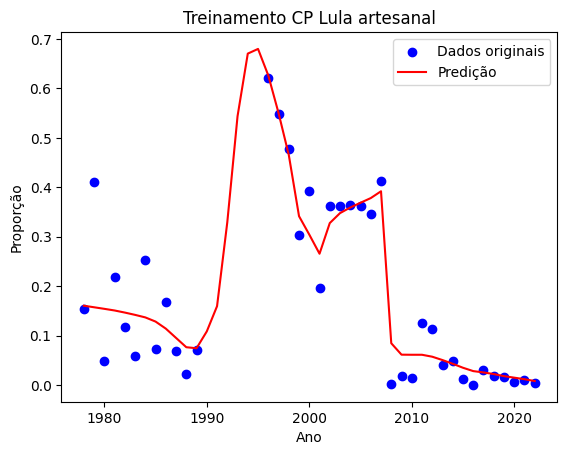

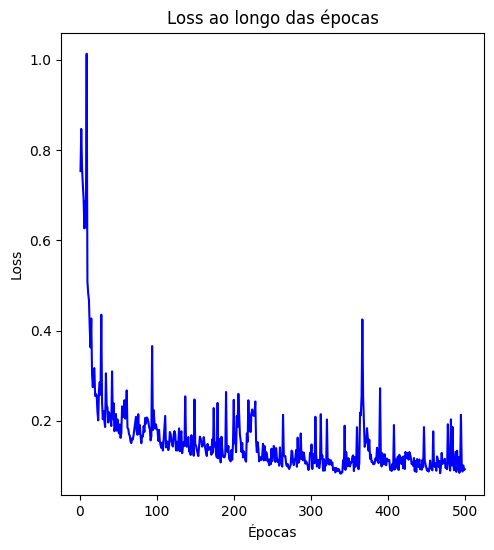

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='leaky_relu', input_shape=(1,)),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(128, activation='leaky_relu'),
    tf.keras.layers.Dense(64, activation='leaky_relu'),
    tf.keras.layers.Dense(32, activation='leaky_relu'),
    tf.keras.layers.Dense(1, activation='leaky_relu')
    
])

opt = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])

print_every_100_epochs = PrintEveryNEpochs(N=100) 

history = model.fit(
    x_normalized, y_normalized, 
    epochs=500, 
    batch_size=12, 
    steps_per_epoch=50, 
    verbose=0,  
    callbacks=[print_every_100_epochs]
)
x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized)
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Proporção Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Proporção Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')

plt.scatter(df_combined['Ano'], df_combined['Proporção Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Proporção Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Proporção')
plt.title('Treinamento CP Lula artesanal')
plt.legend()
plt.show()

loss_values = history.history['loss']
#accuracy_values = history.history['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()